In [2]:
import matplotlib as mp
import matplotlib.pyplot as plt
import numpy as np
import csv
import pandas as pd

In [3]:
x=[] 

I have taken record 117 from https://www.physionet.org/cgi-bin/atm/ATM with options: length- to end,time format in secs, MLII signal.

In [4]:
with open(r'C:\Users\Ojas Mithbavkar\Desktop\samples (5).csv','r') as csvFile:
    csvreader=csv.reader(csvFile , delimiter=',')
    #print(list(csvreader))
    for row in csvreader:
        x.append(row)

Converts x into an array:

In [5]:
b = np.asarray(x, dtype=np.float64, order='C')
#b[:,1]

In [6]:

print(b[:,1])
T=360
N=54

[-0.925 -0.925 -0.925 ... -0.85  -0.865 -0.855]


data is the array of amplitudes, array of length 21600 for 60 sec samples.

In [7]:
data=b[:,1]

In [8]:
data

array([-0.925, -0.925, -0.925, ..., -0.85 , -0.865, -0.855])

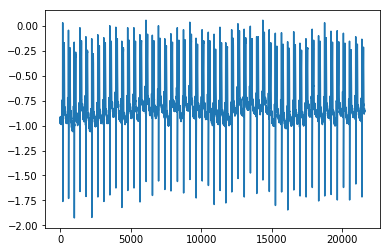

In [9]:
plt.plot(data)

Now we apply a low pass filter using scipy. The transfer function is ((1-z^-6)^-2)/((1-z^-1)^2). They first argument is the list of coefficients of the numerator, the second argument is the list of coefficients of the denominator, and third argument is the signal on which we apply the filter.

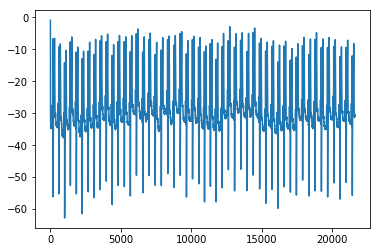

In [10]:
from scipy import signal as sig
data1 = sig.lfilter([1,0,0,0,0,0,-2,0,0,0,0,0,1],[1,-2,1],data)
plt.plot(data1)

Now we apply high pass filter with transfer function (-1+32z^-16+z^-32)/(1+z^-1) and similar arguments.

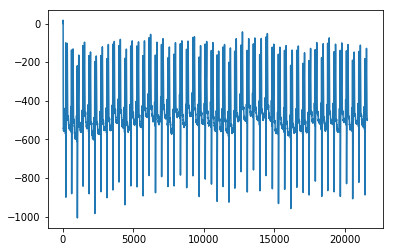

In [12]:
data2 = sig.lfilter([-1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,32,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1],[1,1],data1)
plt.plot(data2)

Now we apply differentiation step. The equation of this step is y[nT] = (1/8T)* ( -x[nT-2T] -2x[nT-T] + 2x[nT+T]+ x[nT+2T])

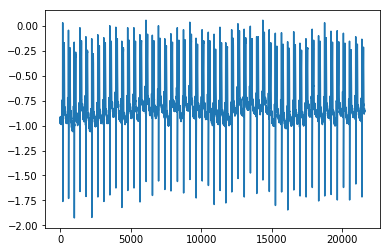

In [13]:
data3 = np.zeros(data.shape)
for t in range(2,len(data2)-2):
    data3[t] = (-1*data2[t-2]-2*data2[t-1]+2*data2[t+1]+data2[t+2])/(8*T)
plt.plot(data)

Now we perform squaring operation and also remove outliers.

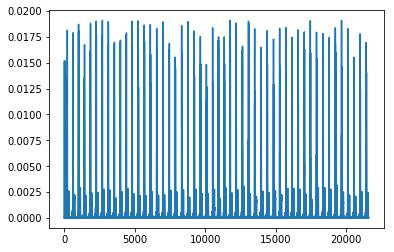

In [14]:
data4 = data3*data3
avg = np.average(data4)
stdev = np.std(data4)
for t in range(len(data4)):
    if(data4[t]>=avg+2*stdev):
        data4[t] = 0
plt.plot(data4)

Now we perform moving window integration. The paper uses N=30 for 200 samples/sec. We use N=54 for 360 samples/sec. Then equation is (1/𝑁)(x[nT- (N - 1) T] +x[nT- (N - 2) T] + … x[nT])


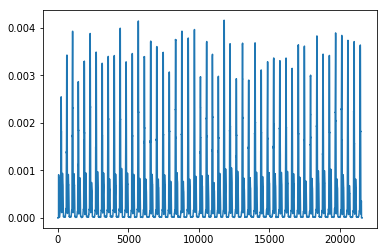

In [15]:
data5 = np.zeros(data.shape)
for t in range(N,len(data4)-N):
    for j in range(N):
        data5[t]+= data4[t-j]
data5 /= N
plt.plot(data5)

Now we get to finding the R peaks. First finding the max peak.

In [167]:
maxim=max(data5)
maxim

0.004161541823899482

In [168]:
avg=np.average(data5)
avg

0.000596924827976151

Using function find_peaks to find R peaks. Setting a threshold of around 0.006. 1 sample width corresponds to 0.0027 s. 2 QRS complexes cannot occur within 200 ms of each other. Hence setting minimum distance as 1 (1 index corresponds to 0.0027 s).

In [16]:
peak=sig.find_peaks(data5,height=0.003,distance=1)

In [17]:
print('Indices of R peaks',peak[0])

Indices of R peaks [  634   650  1051  1057  1066  1868  1886  2297  2309  2710  2727  3137
  3150  3580  3992  4010  4431  4834  4844  4852  5277  5287  5716  6132
  6140  6149  6584  6595  7017  7027  7035  7464  7473  7477  7481  7899
  7913  8353  8370  8795  8805  8812  8822  9244  9259  9694  9701 10555
 10569 10964 10976 11795 11806 12215 12226 13098 13113 14001 14422 14425
 14435 14890 15312 15323 15756 15766 16198 16616 16631 17056 17073 17486
 17500 17502 17940 18380 18390 18396 18809 18826 19259 19273 19705 19716
 20142 20158 20591 21020 21034 21468]


Now we find the average R-R interval.

In [18]:
diff=[]
for j in range(len(peak[0])-1):
    diff.append(peak[0][j]-peak[0][j+1])
    

In [19]:
rr=abs(np.average(diff))

In [20]:
rr

234.08988764044943

In [21]:
heartrate= 60000/(2*rr)

In [22]:
print('Heartrate in bpm is' , int(heartrate)) #bpm

Heartrate in bpm is 128
